# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'



import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

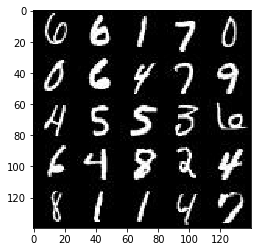

In [3]:
show_n_images = 25


%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  

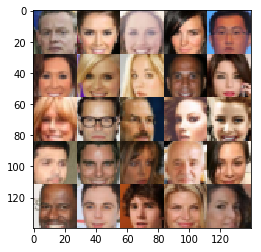

In [4]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network

- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure that I have the correct version of TensorFlow and access to a GPU

In [5]:

from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    #inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    #inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    #learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
 `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network. 

In [32]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    keep_prob = 0.9
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28X28X5
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', kernel_initializer = tf.contrib.layers.xavier_initializer())
        # As Per Suggestion we should avoid doing batch normalization after in first layer
        #x1 = tf.layers.batch_normalization(x1, training=True) 
        x1 = tf.maximum(alpha * x1, x1)
        print("discriminator shape, 1: {}".format(x1.shape))
        #Now 14X14X32
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        print("discriminator shape, 2: {}".format(x2.shape))
        #Now 7X7X128
        
        x3 = tf.layers.conv2d(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        print("discriminator shape, 3: {}".format(x3.shape))
        #Now 7X7X128
        
                
        x4 = tf.layers.conv2d(x3, 256, 5, strides=2, padding='SAME')
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha * x4, x4)
        print("discriminator shape, 4: {}".format(x4.shape))
        #Now 4X4X256
        
        dropout = tf.nn.dropout(x4, keep_prob=keep_prob)
        # Reshape it to 4x4
        flat = tf.reshape(x4, (-1, 4*4*256)) 
        logits = tf.layers.dense(flat, 1) # O/P of discriminator is either 0 or 1 (real or fake)
        out = tf.sigmoid(logits)
        print("discriminator shape, flat: {}".format(flat.shape))
        print("discriminator shape, logits: {}".format(logits.shape))
        #print("discriminator shape, out: {}".format(out.shape))
        return out, logits



tests.test_discriminator(discriminator, tf)

discriminator shape, 1: (?, 14, 14, 64)
discriminator shape, 2: (?, 7, 7, 128)
discriminator shape, 3: (?, 7, 7, 128)
discriminator shape, 4: (?, 4, 4, 256)
discriminator shape, flat: (?, 4096)
discriminator shape, logits: (?, 1)
discriminator shape, 1: (?, 14, 14, 64)
discriminator shape, 2: (?, 7, 7, 128)
discriminator shape, 3: (?, 7, 7, 128)
discriminator shape, 4: (?, 4, 4, 256)
discriminator shape, flat: (?, 4096)
discriminator shape, logits: (?, 1)
Tests Passed


### Generator
`generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  

In [36]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    reuse = not is_train # if is_Train=False then reuse=True
    #print(out_channel_dim)
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*256)
        print("generator shape, 1-dense: {}".format(x.shape))
        
        
        #Reshape it to start the CONV layer
        x1 = tf.reshape(x, (-1, 4, 4, 256)) #-1 is used to flatten
        #x1 = tf.layers.batch_normalization(x1, training=is_train) 
        x1 = tf.maximum(alpha * x1, x1)
        #Now it is become 4*4*256
        print("generator shape, 1-reshape: {}".format(x1.shape))
        
        
        #Conv1 7*7*256
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='VALID', kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #Now it is become 7*7*256
        print("generator shape, 2: {}".format(x2.shape))
        
        #Conv2 14*14*128
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #Now it is become 14*14*128
        print("generator shape, 3: {}".format(x3.shape))
        
        # Output layer, 32x32x3, No batch Norm and no Leaky Relu
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='SAME')
        out = tf.tanh(logits)
        print("generator shape, logits: {}".format(logits.shape))
        #Now it is become 28x28x5
    return out


tests.test_generator(generator, tf)

generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 5)
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 5)
Tests Passed


### Loss
`model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Using the following functions:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [37]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    alpha=0.2
    smoothing = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True) #no reuse
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1-smoothing)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

tests.test_model_loss(model_loss)

generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 4)
discriminator shape, 1: (?, 14, 14, 64)
discriminator shape, 2: (?, 7, 7, 128)
discriminator shape, 3: (?, 7, 7, 128)
discriminator shape, 4: (?, 4, 4, 256)
discriminator shape, flat: (?, 4096)
discriminator shape, logits: (?, 1)
discriminator shape, 1: (?, 14, 14, 64)
discriminator shape, 2: (?, 7, 7, 128)
discriminator shape, 3: (?, 7, 7, 128)
discriminator shape, 4: (?, 4, 4, 256)
discriminator shape, flat: (?, 4096)
discriminator shape, logits: (?, 1)
Tests Passed


### Optimization
`model_opt` to create the optimization operations for the GANs. Used [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filtered the variables with names that are in the discriminator and generator scope names. 

In [38]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output


In [39]:

import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
`train` to build and train the GANs.  Following functions are used:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Used `show_generator_output` to show `generator` output while training. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [50]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    losses = []
    show_every = 100
    print_every = 10
    n_images = 25
    _, image_width, image_height, image_channels = data_shape

    input_, z_input_, learning_rate_ = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_, z_input_, image_channels)
    dis_train_opt, gen_train_opt = model_opt(dis_loss, gen_loss, learning_rate_, beta1)

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                batch_images *= 2
                
                feed_dict = {
                    input_: batch_images,
                    z_input_: batch_z,
                    learning_rate_: learning_rate
                }
                
                sess.run(dis_train_opt, feed_dict=feed_dict)
                sess.run(gen_train_opt, feed_dict=feed_dict)
                sess.run(gen_train_opt, feed_dict=feed_dict)
                
                if steps % print_every == 0:
                    train_loss_dis = dis_loss.eval({z_input_: batch_z, input_: batch_images})
                    train_loss_gen = gen_loss.eval({z_input_: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_dis),
                          "Generator Loss: {:.4f}...".format(train_loss_gen),)
                    losses.append((train_loss_dis, train_loss_gen))
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input_, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)
discriminator shape, 1: (?, 14, 14, 64)
discriminator shape, 2: (?, 7, 7, 128)
discriminator shape, 3: (?, 7, 7, 128)
discriminator shape, 4: (?, 4, 4, 256)
discriminator shape, flat: (?, 4096)
discriminator shape, logits: (?, 1)
discriminator shape, 1: (?, 14, 14, 64)
discriminator shape, 2: (?, 7, 7, 128)
discriminator shape, 3: (?, 7, 7, 128)
discriminator shape, 4: (?, 4, 4, 256)
discriminator shape, flat: (?, 4096)
discriminator shape, logits: (?, 1)
Epoch 1/2... Discriminator Loss: 3.3626... Generator Loss: 0.9757...
Epoch 1/2... Discriminator Loss: 2.3649... Generator Loss: 2.6892...
Epoch 1/2... Discriminator Loss: 1.9054... Generator Loss: 1.3286...
Epoch 1/2... Discriminator Loss: 1.7378... Generator Loss: 0.9856...
Epoch 1/2... Discriminator Loss: 1.6630... Generator Loss: 0.9959...
Epoc

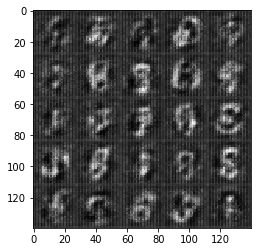

Epoch 1/2... Discriminator Loss: 1.3393... Generator Loss: 1.0581...
Epoch 1/2... Discriminator Loss: 1.4568... Generator Loss: 0.4434...
Epoch 1/2... Discriminator Loss: 1.6068... Generator Loss: 0.3635...
Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.4845...
Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.5268...
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 0.6369...
Epoch 1/2... Discriminator Loss: 1.5620... Generator Loss: 0.3738...
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 0.6248...
Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 0.4798...
Epoch 1/2... Discriminator Loss: 1.5725... Generator Loss: 0.3662...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


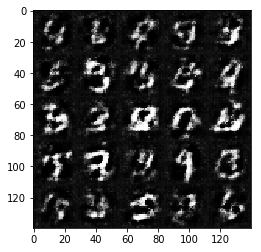

Epoch 1/2... Discriminator Loss: 1.2230... Generator Loss: 0.6336...
Epoch 1/2... Discriminator Loss: 2.0431... Generator Loss: 0.2178...
Epoch 1/2... Discriminator Loss: 1.5548... Generator Loss: 0.3968...
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.5049...
Epoch 1/2... Discriminator Loss: 1.2720... Generator Loss: 0.6120...
Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 0.5412...
Epoch 1/2... Discriminator Loss: 1.5661... Generator Loss: 0.3843...
Epoch 1/2... Discriminator Loss: 1.5889... Generator Loss: 0.3672...
Epoch 1/2... Discriminator Loss: 1.6423... Generator Loss: 0.4003...
Epoch 1/2... Discriminator Loss: 1.4389... Generator Loss: 0.4919...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


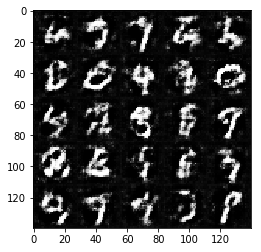

Epoch 1/2... Discriminator Loss: 1.6211... Generator Loss: 0.3664...
Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.6452...
Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 0.9438...
Epoch 1/2... Discriminator Loss: 1.7792... Generator Loss: 0.3097...
Epoch 1/2... Discriminator Loss: 1.8300... Generator Loss: 0.2836...
Epoch 1/2... Discriminator Loss: 1.4966... Generator Loss: 0.4152...
Epoch 1/2... Discriminator Loss: 1.9877... Generator Loss: 0.2627...
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 0.5965...
Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 0.6041...
Epoch 1/2... Discriminator Loss: 1.9076... Generator Loss: 1.2670...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


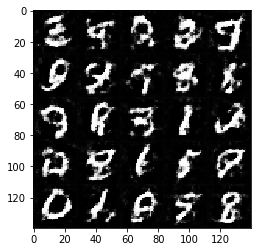

Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 0.6687...
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 0.5780...
Epoch 1/2... Discriminator Loss: 1.5802... Generator Loss: 0.3951...
Epoch 1/2... Discriminator Loss: 1.5294... Generator Loss: 0.4440...
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.4299...
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 1.0948...
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 0.6089...
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.5055...
Epoch 1/2... Discriminator Loss: 2.4778... Generator Loss: 0.1668...
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.7106...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


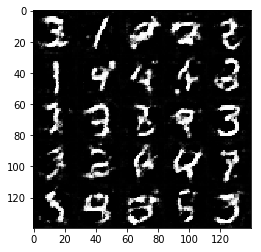

Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 0.5649...
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 0.8910...
Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 0.6971...
Epoch 1/2... Discriminator Loss: 1.6561... Generator Loss: 0.6446...
Epoch 1/2... Discriminator Loss: 1.5686... Generator Loss: 0.4083...
Epoch 1/2... Discriminator Loss: 1.0829... Generator Loss: 1.0082...
Epoch 1/2... Discriminator Loss: 2.5318... Generator Loss: 0.1525...
Epoch 1/2... Discriminator Loss: 1.5287... Generator Loss: 0.4269...
Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 0.9160...
Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 0.6855...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


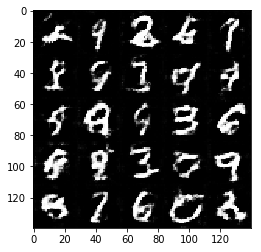

Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 1.1768...
Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.4502...
Epoch 1/2... Discriminator Loss: 1.8398... Generator Loss: 0.2862...
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.6049...
Epoch 1/2... Discriminator Loss: 1.1732... Generator Loss: 0.6519...
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.1939...
Epoch 1/2... Discriminator Loss: 1.3165... Generator Loss: 0.7186...
Epoch 1/2... Discriminator Loss: 2.1474... Generator Loss: 2.4814...
Epoch 1/2... Discriminator Loss: 1.5348... Generator Loss: 1.0990...
Epoch 1/2... Discriminator Loss: 1.5440... Generator Loss: 0.4256...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


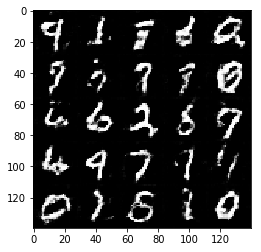

Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.7027...
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 0.6468...
Epoch 1/2... Discriminator Loss: 1.7670... Generator Loss: 0.7927...
Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 1.0548...
Epoch 1/2... Discriminator Loss: 1.0285... Generator Loss: 0.8793...
Epoch 1/2... Discriminator Loss: 0.9581... Generator Loss: 1.0994...
Epoch 1/2... Discriminator Loss: 1.5607... Generator Loss: 0.4720...
Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 0.6548...
Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 0.8819...
Epoch 1/2... Discriminator Loss: 1.7834... Generator Loss: 2.1211...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


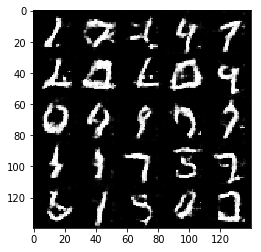

Epoch 1/2... Discriminator Loss: 1.6842... Generator Loss: 0.3574...
Epoch 1/2... Discriminator Loss: 1.4622... Generator Loss: 0.4447...
Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 1.1304...
Epoch 1/2... Discriminator Loss: 1.5231... Generator Loss: 0.4638...
Epoch 1/2... Discriminator Loss: 0.7783... Generator Loss: 1.4415...
Epoch 1/2... Discriminator Loss: 2.0125... Generator Loss: 2.2921...
Epoch 1/2... Discriminator Loss: 1.0841... Generator Loss: 0.9338...
Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 0.4692...
Epoch 1/2... Discriminator Loss: 1.3140... Generator Loss: 0.6387...
Epoch 1/2... Discriminator Loss: 2.0616... Generator Loss: 0.2413...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


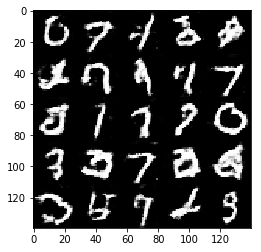

Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.4644...
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 0.9387...
Epoch 1/2... Discriminator Loss: 1.5662... Generator Loss: 1.4102...
Epoch 2/2... Discriminator Loss: 1.5148... Generator Loss: 0.4246...
Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 1.2058...
Epoch 2/2... Discriminator Loss: 1.1360... Generator Loss: 0.7492...
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 0.7198...
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.5660...
Epoch 2/2... Discriminator Loss: 2.6416... Generator Loss: 0.1421...
Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 1.1582...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


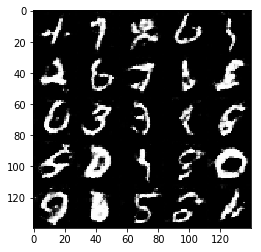

Epoch 2/2... Discriminator Loss: 1.0934... Generator Loss: 1.0868...
Epoch 2/2... Discriminator Loss: 1.7347... Generator Loss: 0.3515...
Epoch 2/2... Discriminator Loss: 1.7379... Generator Loss: 0.3462...
Epoch 2/2... Discriminator Loss: 1.0588... Generator Loss: 1.1181...
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 1.7485...
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 0.6066...
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.5630...
Epoch 2/2... Discriminator Loss: 1.4766... Generator Loss: 0.5432...
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.7262...
Epoch 2/2... Discriminator Loss: 1.6810... Generator Loss: 0.3679...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


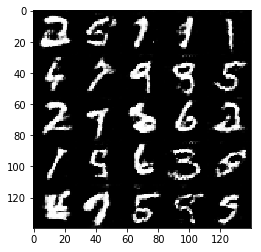

Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 0.7802...
Epoch 2/2... Discriminator Loss: 1.7191... Generator Loss: 0.3347...
Epoch 2/2... Discriminator Loss: 1.4840... Generator Loss: 2.8889...
Epoch 2/2... Discriminator Loss: 1.7023... Generator Loss: 0.3588...
Epoch 2/2... Discriminator Loss: 1.7269... Generator Loss: 0.3231...
Epoch 2/2... Discriminator Loss: 1.6387... Generator Loss: 0.3950...
Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 0.5565...
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 0.6844...
Epoch 2/2... Discriminator Loss: 2.4185... Generator Loss: 0.1884...
Epoch 2/2... Discriminator Loss: 1.3324... Generator Loss: 1.5993...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


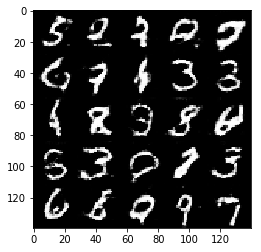

Epoch 2/2... Discriminator Loss: 1.7546... Generator Loss: 0.3245...
Epoch 2/2... Discriminator Loss: 0.9573... Generator Loss: 1.2786...
Epoch 2/2... Discriminator Loss: 1.0387... Generator Loss: 1.7944...
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.7264...
Epoch 2/2... Discriminator Loss: 0.9365... Generator Loss: 1.4715...
Epoch 2/2... Discriminator Loss: 1.5591... Generator Loss: 0.4085...
Epoch 2/2... Discriminator Loss: 1.9051... Generator Loss: 0.3042...
Epoch 2/2... Discriminator Loss: 2.2951... Generator Loss: 0.1896...
Epoch 2/2... Discriminator Loss: 2.1287... Generator Loss: 0.2232...
Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 0.9532...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


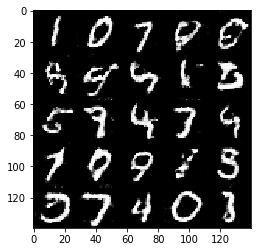

Epoch 2/2... Discriminator Loss: 1.5073... Generator Loss: 0.4259...
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 0.8727...
Epoch 2/2... Discriminator Loss: 1.4133... Generator Loss: 0.5395...
Epoch 2/2... Discriminator Loss: 2.0814... Generator Loss: 0.2325...
Epoch 2/2... Discriminator Loss: 1.5437... Generator Loss: 0.4250...
Epoch 2/2... Discriminator Loss: 1.3026... Generator Loss: 0.6125...
Epoch 2/2... Discriminator Loss: 1.4257... Generator Loss: 0.4765...
Epoch 2/2... Discriminator Loss: 1.5359... Generator Loss: 0.4113...
Epoch 2/2... Discriminator Loss: 2.3181... Generator Loss: 0.2325...
Epoch 2/2... Discriminator Loss: 1.2990... Generator Loss: 0.6244...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


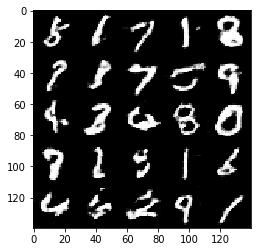

Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 1.7931...
Epoch 2/2... Discriminator Loss: 1.5263... Generator Loss: 0.4262...
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 1.7676...
Epoch 2/2... Discriminator Loss: 1.6851... Generator Loss: 0.3533...
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 0.7553...
Epoch 2/2... Discriminator Loss: 0.8552... Generator Loss: 1.0654...
Epoch 2/2... Discriminator Loss: 1.0354... Generator Loss: 1.4225...
Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 0.5723...
Epoch 2/2... Discriminator Loss: 1.3264... Generator Loss: 0.5582...
Epoch 2/2... Discriminator Loss: 1.5707... Generator Loss: 0.3982...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


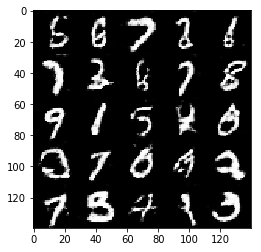

Epoch 2/2... Discriminator Loss: 1.0505... Generator Loss: 0.8119...
Epoch 2/2... Discriminator Loss: 0.8467... Generator Loss: 1.4717...
Epoch 2/2... Discriminator Loss: 1.9591... Generator Loss: 0.3465...
Epoch 2/2... Discriminator Loss: 1.2577... Generator Loss: 0.5822...
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 0.8198...
Epoch 2/2... Discriminator Loss: 0.8276... Generator Loss: 1.1736...
Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 1.6439...
Epoch 2/2... Discriminator Loss: 1.5511... Generator Loss: 0.4289...
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.5282...
Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.5424...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


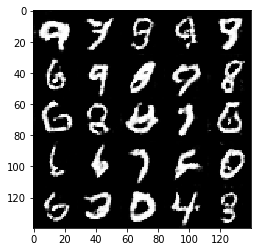

Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 0.6409...
Epoch 2/2... Discriminator Loss: 2.7572... Generator Loss: 0.1186...
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 1.0694...
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 0.7948...
Epoch 2/2... Discriminator Loss: 1.5292... Generator Loss: 0.4426...
Epoch 2/2... Discriminator Loss: 1.7231... Generator Loss: 0.3367...
Epoch 2/2... Discriminator Loss: 1.6202... Generator Loss: 0.3838...
Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 0.7402...
Epoch 2/2... Discriminator Loss: 0.7455... Generator Loss: 1.3759...
Epoch 2/2... Discriminator Loss: 1.8668... Generator Loss: 0.3052...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


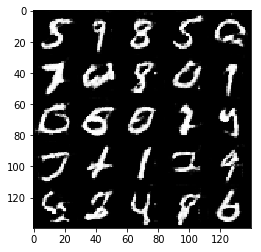

Epoch 2/2... Discriminator Loss: 2.1569... Generator Loss: 0.2177...
Epoch 2/2... Discriminator Loss: 1.0114... Generator Loss: 0.8375...
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 0.6807...
Epoch 2/2... Discriminator Loss: 1.0195... Generator Loss: 1.8237...
Epoch 2/2... Discriminator Loss: 1.1333... Generator Loss: 0.8081...
Epoch 2/2... Discriminator Loss: 1.7857... Generator Loss: 0.3050...
Epoch 2/2... Discriminator Loss: 2.1614... Generator Loss: 0.2855...
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 1.2678...
Epoch 2/2... Discriminator Loss: 2.2238... Generator Loss: 0.2076...
Epoch 2/2... Discriminator Loss: 1.4125... Generator Loss: 0.4640...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 1)


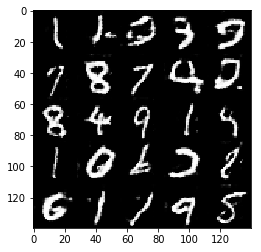

Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.2087...
Epoch 2/2... Discriminator Loss: 1.3352... Generator Loss: 0.5297...
Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 1.4114...
Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 0.9165...
Epoch 2/2... Discriminator Loss: 1.0276... Generator Loss: 1.7836...
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 0.9718...
Epoch 2/2... Discriminator Loss: 2.6377... Generator Loss: 3.4975...


In [51]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)
discriminator shape, 1: (?, 14, 14, 64)
discriminator shape, 2: (?, 7, 7, 128)
discriminator shape, 3: (?, 7, 7, 128)
discriminator shape, 4: (?, 4, 4, 256)
discriminator shape, flat: (?, 4096)
discriminator shape, logits: (?, 1)
discriminator shape, 1: (?, 14, 14, 64)
discriminator shape, 2: (?, 7, 7, 128)
discriminator shape, 3: (?, 7, 7, 128)
discriminator shape, 4: (?, 4, 4, 256)
discriminator shape, flat: (?, 4096)
discriminator shape, logits: (?, 1)
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 2.3583...
Epoch 1/2... Discriminator Loss: 2.0964... Generator Loss: 2.8447...
Epoch 1/2... Discriminator Loss: 1.2219... Generator Loss: 2.6559...
Epoch 1/2... Discriminator Loss: 1.5283... Generator Loss: 0.6066...
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.7592...
Epoc

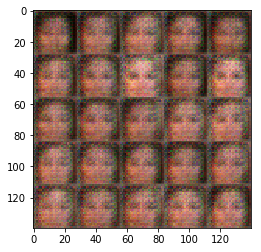

Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.8044...
Epoch 1/2... Discriminator Loss: 1.6461... Generator Loss: 1.3334...
Epoch 1/2... Discriminator Loss: 1.6342... Generator Loss: 0.5180...
Epoch 1/2... Discriminator Loss: 1.5571... Generator Loss: 0.5482...
Epoch 1/2... Discriminator Loss: 1.5256... Generator Loss: 0.8338...
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 1.6472...
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 0.8972...
Epoch 1/2... Discriminator Loss: 1.5564... Generator Loss: 0.5040...
Epoch 1/2... Discriminator Loss: 1.5160... Generator Loss: 0.6514...
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 1.0003...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


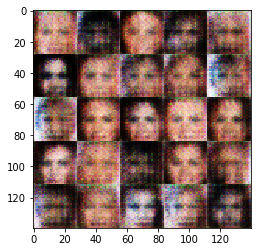

Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 0.7696...
Epoch 1/2... Discriminator Loss: 1.6776... Generator Loss: 0.4001...
Epoch 1/2... Discriminator Loss: 1.4285... Generator Loss: 0.8087...
Epoch 1/2... Discriminator Loss: 1.2954... Generator Loss: 0.7454...
Epoch 1/2... Discriminator Loss: 1.5284... Generator Loss: 0.7463...
Epoch 1/2... Discriminator Loss: 1.7039... Generator Loss: 0.8799...
Epoch 1/2... Discriminator Loss: 1.7126... Generator Loss: 1.0142...
Epoch 1/2... Discriminator Loss: 1.5453... Generator Loss: 0.9973...
Epoch 1/2... Discriminator Loss: 1.7095... Generator Loss: 1.0854...
Epoch 1/2... Discriminator Loss: 1.5242... Generator Loss: 1.3953...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


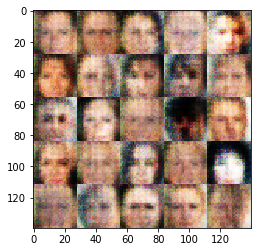

Epoch 1/2... Discriminator Loss: 1.4707... Generator Loss: 0.5930...
Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.7242...
Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 0.6583...
Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 0.5366...
Epoch 1/2... Discriminator Loss: 1.5129... Generator Loss: 0.7501...
Epoch 1/2... Discriminator Loss: 1.5224... Generator Loss: 0.5674...
Epoch 1/2... Discriminator Loss: 1.4767... Generator Loss: 1.1373...
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.9351...
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 1.0249...
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.9182...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


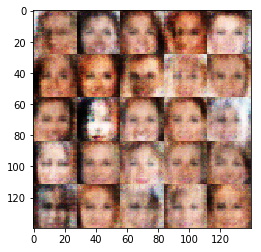

Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 1.0061...
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.5078...
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.7272...
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.6913...
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.5521...
Epoch 1/2... Discriminator Loss: 1.4969... Generator Loss: 0.5845...
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 0.7001...
Epoch 1/2... Discriminator Loss: 1.4070... Generator Loss: 0.7365...
Epoch 1/2... Discriminator Loss: 1.5123... Generator Loss: 0.9276...
Epoch 1/2... Discriminator Loss: 1.4313... Generator Loss: 0.7720...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


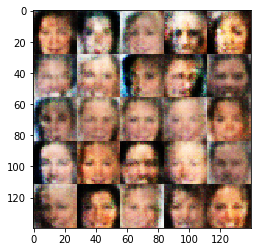

Epoch 1/2... Discriminator Loss: 1.5248... Generator Loss: 0.9097...
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.6481...
Epoch 1/2... Discriminator Loss: 1.4789... Generator Loss: 0.6098...
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.7477...
Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 0.6613...
Epoch 1/2... Discriminator Loss: 1.4324... Generator Loss: 0.6364...
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.9491...
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 0.9559...
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.6986...
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.7540...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


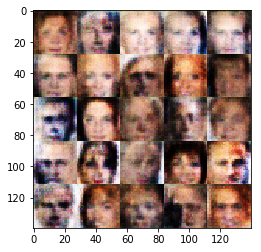

Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.8549...
Epoch 1/2... Discriminator Loss: 1.4713... Generator Loss: 0.8885...
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.5839...
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.8635...
Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 0.7092...
Epoch 1/2... Discriminator Loss: 1.4637... Generator Loss: 0.9831...
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.6242...
Epoch 1/2... Discriminator Loss: 1.4620... Generator Loss: 0.5521...
Epoch 1/2... Discriminator Loss: 1.4582... Generator Loss: 0.5778...
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.6207...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


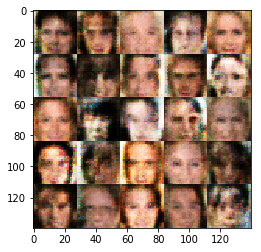

Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.5657...
Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.7025...
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.6542...
Epoch 1/2... Discriminator Loss: 1.4609... Generator Loss: 0.6824...
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.7183...
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 0.7797...
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 0.8967...
Epoch 1/2... Discriminator Loss: 1.4773... Generator Loss: 0.7288...
Epoch 1/2... Discriminator Loss: 1.3965... Generator Loss: 0.6568...
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 0.9092...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


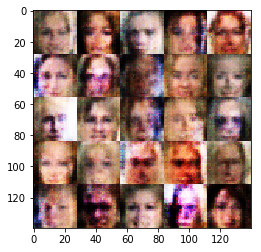

Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.7107...
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.6632...
Epoch 1/2... Discriminator Loss: 1.5416... Generator Loss: 0.5012...
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.7317...
Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.8588...
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.7303...
Epoch 1/2... Discriminator Loss: 1.4685... Generator Loss: 0.6470...
Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 0.7534...
Epoch 1/2... Discriminator Loss: 1.4207... Generator Loss: 0.6572...
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.7136...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


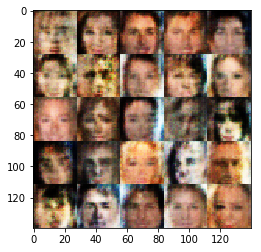

Epoch 1/2... Discriminator Loss: 1.4177... Generator Loss: 0.9097...
Epoch 1/2... Discriminator Loss: 1.4212... Generator Loss: 0.6440...
Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.6241...
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.6830...
Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 0.9295...
Epoch 1/2... Discriminator Loss: 1.4651... Generator Loss: 0.5527...
Epoch 1/2... Discriminator Loss: 1.3364... Generator Loss: 0.9446...
Epoch 1/2... Discriminator Loss: 1.4446... Generator Loss: 0.6505...
Epoch 1/2... Discriminator Loss: 1.4203... Generator Loss: 0.6743...
Epoch 1/2... Discriminator Loss: 1.4622... Generator Loss: 0.5773...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


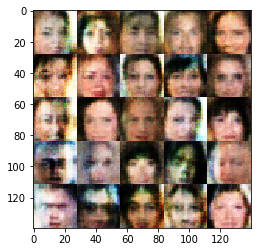

Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 0.7247...
Epoch 1/2... Discriminator Loss: 1.4224... Generator Loss: 0.7009...
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.5805...
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.8728...
Epoch 1/2... Discriminator Loss: 1.5010... Generator Loss: 0.6931...
Epoch 1/2... Discriminator Loss: 1.4855... Generator Loss: 0.7778...
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.8391...
Epoch 1/2... Discriminator Loss: 1.5676... Generator Loss: 0.4569...
Epoch 1/2... Discriminator Loss: 1.5506... Generator Loss: 0.4983...
Epoch 1/2... Discriminator Loss: 1.4184... Generator Loss: 0.8101...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


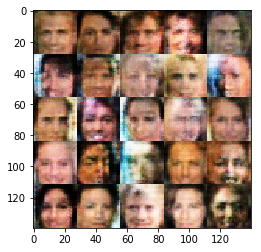

Epoch 1/2... Discriminator Loss: 1.5230... Generator Loss: 0.5370...
Epoch 1/2... Discriminator Loss: 1.4176... Generator Loss: 0.6710...
Epoch 1/2... Discriminator Loss: 1.4966... Generator Loss: 0.5065...
Epoch 1/2... Discriminator Loss: 1.5128... Generator Loss: 0.6643...
Epoch 1/2... Discriminator Loss: 1.5210... Generator Loss: 0.5244...
Epoch 1/2... Discriminator Loss: 1.6874... Generator Loss: 0.3730...
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.7435...
Epoch 1/2... Discriminator Loss: 1.4835... Generator Loss: 0.5069...
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.9949...
Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 0.6994...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


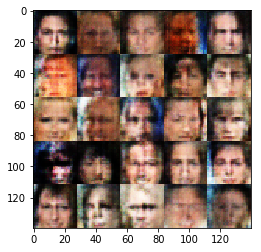

Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.7975...
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.7014...
Epoch 1/2... Discriminator Loss: 1.5474... Generator Loss: 0.8515...
Epoch 1/2... Discriminator Loss: 1.4106... Generator Loss: 0.6661...
Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.5524...
Epoch 1/2... Discriminator Loss: 1.6649... Generator Loss: 0.3808...
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 0.6858...
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.5796...
Epoch 1/2... Discriminator Loss: 1.4221... Generator Loss: 0.5876...
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 0.5295...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


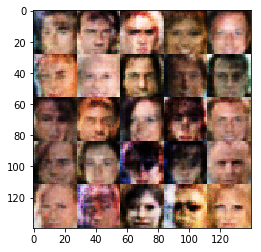

Epoch 1/2... Discriminator Loss: 1.5075... Generator Loss: 0.5718...
Epoch 1/2... Discriminator Loss: 1.5872... Generator Loss: 0.4007...
Epoch 1/2... Discriminator Loss: 1.4557... Generator Loss: 0.6333...
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 0.5018...
Epoch 1/2... Discriminator Loss: 1.5380... Generator Loss: 0.5315...
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.6020...
Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.5853...
Epoch 1/2... Discriminator Loss: 1.5144... Generator Loss: 0.4545...
Epoch 1/2... Discriminator Loss: 1.5657... Generator Loss: 0.4629...
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.5159...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


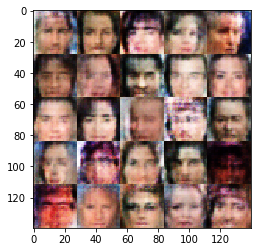

Epoch 1/2... Discriminator Loss: 1.5128... Generator Loss: 0.6199...
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.8069...
Epoch 1/2... Discriminator Loss: 1.5789... Generator Loss: 0.7806...
Epoch 1/2... Discriminator Loss: 1.4177... Generator Loss: 0.6512...
Epoch 1/2... Discriminator Loss: 1.5733... Generator Loss: 0.7841...
Epoch 1/2... Discriminator Loss: 1.5327... Generator Loss: 0.5407...
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 0.6779...
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 0.5131...
Epoch 1/2... Discriminator Loss: 1.7083... Generator Loss: 0.3783...
Epoch 1/2... Discriminator Loss: 1.4420... Generator Loss: 0.5973...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


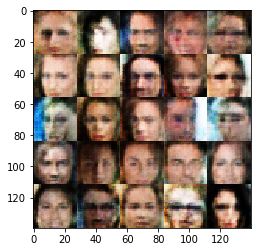

Epoch 1/2... Discriminator Loss: 1.5053... Generator Loss: 0.6077...
Epoch 1/2... Discriminator Loss: 1.5357... Generator Loss: 0.5214...
Epoch 1/2... Discriminator Loss: 1.5510... Generator Loss: 0.4793...
Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.8576...
Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 0.7571...
Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 0.7301...
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.6891...
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.8479...
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.8134...
Epoch 1/2... Discriminator Loss: 1.4872... Generator Loss: 0.5510...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


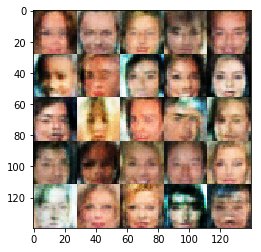

Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.6538...
Epoch 1/2... Discriminator Loss: 1.4768... Generator Loss: 0.5866...
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 0.6458...
Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.5474...
Epoch 1/2... Discriminator Loss: 1.5781... Generator Loss: 0.7436...
Epoch 1/2... Discriminator Loss: 1.4556... Generator Loss: 0.5932...
Epoch 1/2... Discriminator Loss: 1.4351... Generator Loss: 0.8204...
Epoch 1/2... Discriminator Loss: 1.4375... Generator Loss: 0.7569...
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.7705...
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.9477...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


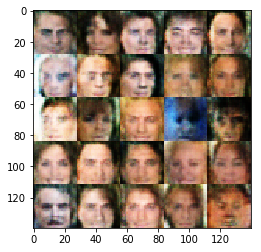

Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.7628...
Epoch 1/2... Discriminator Loss: 1.4382... Generator Loss: 0.5941...
Epoch 1/2... Discriminator Loss: 1.5369... Generator Loss: 0.7517...
Epoch 1/2... Discriminator Loss: 1.4239... Generator Loss: 0.6684...
Epoch 1/2... Discriminator Loss: 1.4757... Generator Loss: 0.9822...
Epoch 1/2... Discriminator Loss: 1.5102... Generator Loss: 0.5084...
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.7684...
Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 0.7240...
Epoch 1/2... Discriminator Loss: 1.4808... Generator Loss: 0.5227...
Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 0.5708...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


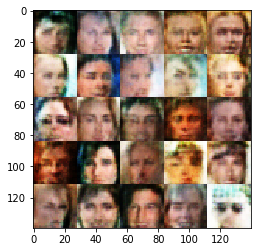

Epoch 1/2... Discriminator Loss: 1.4628... Generator Loss: 0.6171...
Epoch 1/2... Discriminator Loss: 1.4922... Generator Loss: 0.5693...
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 0.6322...
Epoch 1/2... Discriminator Loss: 1.3338... Generator Loss: 0.7442...
Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 0.7847...
Epoch 1/2... Discriminator Loss: 1.4592... Generator Loss: 0.6512...
Epoch 1/2... Discriminator Loss: 1.5231... Generator Loss: 0.6162...
Epoch 1/2... Discriminator Loss: 1.4743... Generator Loss: 0.5473...
Epoch 1/2... Discriminator Loss: 1.4365... Generator Loss: 0.6799...
Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 0.8700...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


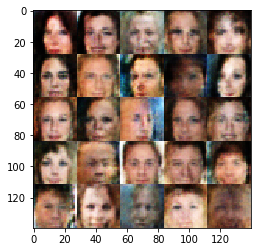

Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.6303...
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.6842...
Epoch 1/2... Discriminator Loss: 1.4219... Generator Loss: 0.5749...
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.9030...
Epoch 1/2... Discriminator Loss: 1.4966... Generator Loss: 0.5510...
Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 0.6035...
Epoch 1/2... Discriminator Loss: 1.4365... Generator Loss: 0.5893...
Epoch 1/2... Discriminator Loss: 1.4946... Generator Loss: 0.5422...
Epoch 1/2... Discriminator Loss: 1.4110... Generator Loss: 0.7481...
Epoch 1/2... Discriminator Loss: 1.5884... Generator Loss: 0.4411...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


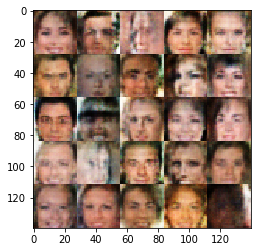

Epoch 1/2... Discriminator Loss: 1.5174... Generator Loss: 0.5834...
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.6702...
Epoch 2/2... Discriminator Loss: 1.4517... Generator Loss: 0.6235...
Epoch 2/2... Discriminator Loss: 1.4309... Generator Loss: 0.5709...
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.8148...
Epoch 2/2... Discriminator Loss: 1.4405... Generator Loss: 0.8705...
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.7188...
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.7858...
Epoch 2/2... Discriminator Loss: 1.4853... Generator Loss: 0.5841...
Epoch 2/2... Discriminator Loss: 1.4656... Generator Loss: 0.4952...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


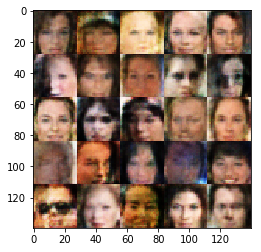

Epoch 2/2... Discriminator Loss: 1.5364... Generator Loss: 0.4730...
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.7032...
Epoch 2/2... Discriminator Loss: 1.5180... Generator Loss: 0.6285...
Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.7037...
Epoch 2/2... Discriminator Loss: 1.4961... Generator Loss: 0.5658...
Epoch 2/2... Discriminator Loss: 1.4392... Generator Loss: 0.7242...
Epoch 2/2... Discriminator Loss: 1.4842... Generator Loss: 0.6846...
Epoch 2/2... Discriminator Loss: 1.4278... Generator Loss: 0.6515...
Epoch 2/2... Discriminator Loss: 1.3596... Generator Loss: 0.6889...
Epoch 2/2... Discriminator Loss: 1.4573... Generator Loss: 0.5420...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


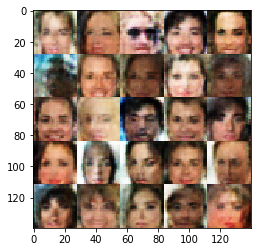

Epoch 2/2... Discriminator Loss: 1.4395... Generator Loss: 0.6636...
Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 0.8040...
Epoch 2/2... Discriminator Loss: 1.5111... Generator Loss: 0.7493...
Epoch 2/2... Discriminator Loss: 1.4058... Generator Loss: 0.9293...
Epoch 2/2... Discriminator Loss: 1.4680... Generator Loss: 0.6277...
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.6305...
Epoch 2/2... Discriminator Loss: 1.4765... Generator Loss: 0.6662...
Epoch 2/2... Discriminator Loss: 1.4403... Generator Loss: 0.6067...
Epoch 2/2... Discriminator Loss: 1.5710... Generator Loss: 0.4581...
Epoch 2/2... Discriminator Loss: 1.4658... Generator Loss: 0.5922...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


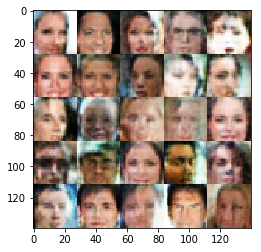

Epoch 2/2... Discriminator Loss: 1.4897... Generator Loss: 0.6919...
Epoch 2/2... Discriminator Loss: 1.4338... Generator Loss: 0.7405...
Epoch 2/2... Discriminator Loss: 1.4058... Generator Loss: 0.7330...
Epoch 2/2... Discriminator Loss: 1.4834... Generator Loss: 0.6460...
Epoch 2/2... Discriminator Loss: 1.4513... Generator Loss: 0.5500...
Epoch 2/2... Discriminator Loss: 1.4492... Generator Loss: 0.8654...
Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 0.8416...
Epoch 2/2... Discriminator Loss: 1.4384... Generator Loss: 0.7363...
Epoch 2/2... Discriminator Loss: 1.4745... Generator Loss: 0.7563...
Epoch 2/2... Discriminator Loss: 1.3566... Generator Loss: 0.6407...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


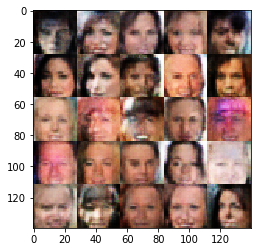

Epoch 2/2... Discriminator Loss: 1.4425... Generator Loss: 0.6150...
Epoch 2/2... Discriminator Loss: 1.4935... Generator Loss: 0.8544...
Epoch 2/2... Discriminator Loss: 1.5078... Generator Loss: 0.4919...
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.6784...
Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 0.6198...
Epoch 2/2... Discriminator Loss: 1.5477... Generator Loss: 0.4588...
Epoch 2/2... Discriminator Loss: 1.4847... Generator Loss: 0.6336...
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.6213...
Epoch 2/2... Discriminator Loss: 1.4767... Generator Loss: 0.5187...
Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.8453...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


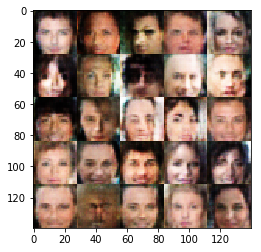

Epoch 2/2... Discriminator Loss: 1.4609... Generator Loss: 0.7905...
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.6012...
Epoch 2/2... Discriminator Loss: 1.4862... Generator Loss: 0.6136...
Epoch 2/2... Discriminator Loss: 1.4381... Generator Loss: 0.7493...
Epoch 2/2... Discriminator Loss: 1.4955... Generator Loss: 0.5253...
Epoch 2/2... Discriminator Loss: 1.4828... Generator Loss: 0.6838...
Epoch 2/2... Discriminator Loss: 1.5255... Generator Loss: 0.5027...
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.7252...
Epoch 2/2... Discriminator Loss: 1.4745... Generator Loss: 0.5681...
Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.5851...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


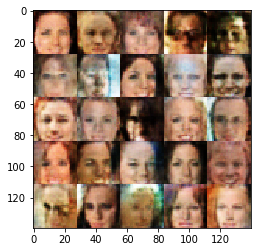

Epoch 2/2... Discriminator Loss: 1.4412... Generator Loss: 0.5498...
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 0.7882...
Epoch 2/2... Discriminator Loss: 1.4654... Generator Loss: 0.6267...
Epoch 2/2... Discriminator Loss: 1.4574... Generator Loss: 0.5794...
Epoch 2/2... Discriminator Loss: 1.5638... Generator Loss: 0.5808...
Epoch 2/2... Discriminator Loss: 1.4042... Generator Loss: 0.6177...
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.6274...
Epoch 2/2... Discriminator Loss: 1.4954... Generator Loss: 0.4770...
Epoch 2/2... Discriminator Loss: 1.4356... Generator Loss: 0.6933...
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.7575...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


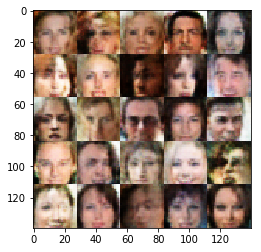

Epoch 2/2... Discriminator Loss: 1.5806... Generator Loss: 0.4248...
Epoch 2/2... Discriminator Loss: 1.4079... Generator Loss: 1.0678...
Epoch 2/2... Discriminator Loss: 1.4243... Generator Loss: 0.7176...
Epoch 2/2... Discriminator Loss: 1.4404... Generator Loss: 0.6875...
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.6846...
Epoch 2/2... Discriminator Loss: 1.3985... Generator Loss: 0.5750...
Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.7811...
Epoch 2/2... Discriminator Loss: 1.4200... Generator Loss: 0.7907...
Epoch 2/2... Discriminator Loss: 1.5483... Generator Loss: 0.4626...
Epoch 2/2... Discriminator Loss: 1.5282... Generator Loss: 0.5557...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


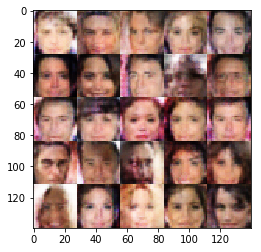

Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.8880...
Epoch 2/2... Discriminator Loss: 1.4791... Generator Loss: 0.5046...
Epoch 2/2... Discriminator Loss: 1.4848... Generator Loss: 0.7795...
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.7242...
Epoch 2/2... Discriminator Loss: 1.5138... Generator Loss: 0.5988...
Epoch 2/2... Discriminator Loss: 1.5383... Generator Loss: 0.4556...
Epoch 2/2... Discriminator Loss: 1.4597... Generator Loss: 0.6368...
Epoch 2/2... Discriminator Loss: 1.5342... Generator Loss: 0.4858...
Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 0.5369...
Epoch 2/2... Discriminator Loss: 1.5964... Generator Loss: 0.4702...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


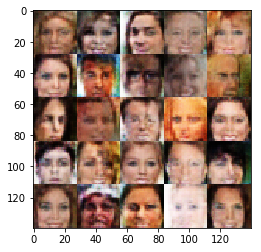

Epoch 2/2... Discriminator Loss: 1.4681... Generator Loss: 0.5570...
Epoch 2/2... Discriminator Loss: 1.4662... Generator Loss: 0.5813...
Epoch 2/2... Discriminator Loss: 1.4604... Generator Loss: 0.8260...
Epoch 2/2... Discriminator Loss: 1.4977... Generator Loss: 0.4693...
Epoch 2/2... Discriminator Loss: 1.4857... Generator Loss: 0.6001...
Epoch 2/2... Discriminator Loss: 1.5197... Generator Loss: 0.4375...
Epoch 2/2... Discriminator Loss: 1.5004... Generator Loss: 0.5386...
Epoch 2/2... Discriminator Loss: 1.5072... Generator Loss: 0.5936...
Epoch 2/2... Discriminator Loss: 1.4773... Generator Loss: 0.6497...
Epoch 2/2... Discriminator Loss: 1.4521... Generator Loss: 0.5425...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


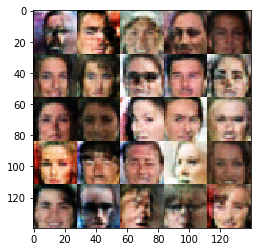

Epoch 2/2... Discriminator Loss: 1.5309... Generator Loss: 0.4483...
Epoch 2/2... Discriminator Loss: 1.4861... Generator Loss: 0.5660...
Epoch 2/2... Discriminator Loss: 1.6981... Generator Loss: 0.4189...
Epoch 2/2... Discriminator Loss: 1.5464... Generator Loss: 0.6672...
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.7438...
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.7047...
Epoch 2/2... Discriminator Loss: 1.4916... Generator Loss: 0.6650...
Epoch 2/2... Discriminator Loss: 1.4595... Generator Loss: 0.5263...
Epoch 2/2... Discriminator Loss: 1.5863... Generator Loss: 0.4021...
Epoch 2/2... Discriminator Loss: 1.6006... Generator Loss: 0.4749...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


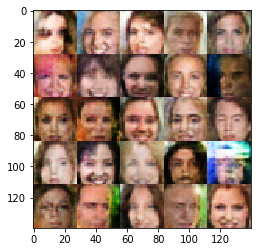

Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 0.8064...
Epoch 2/2... Discriminator Loss: 1.4871... Generator Loss: 0.8643...
Epoch 2/2... Discriminator Loss: 1.5665... Generator Loss: 0.4606...
Epoch 2/2... Discriminator Loss: 1.6119... Generator Loss: 0.8309...
Epoch 2/2... Discriminator Loss: 1.5166... Generator Loss: 0.6740...
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.6735...
Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 0.7856...
Epoch 2/2... Discriminator Loss: 1.4279... Generator Loss: 0.7952...
Epoch 2/2... Discriminator Loss: 1.4159... Generator Loss: 0.7072...
Epoch 2/2... Discriminator Loss: 1.4583... Generator Loss: 0.6095...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


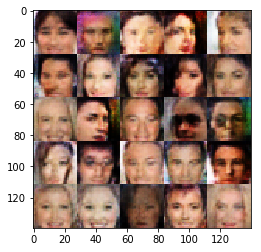

Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.9988...
Epoch 2/2... Discriminator Loss: 1.5831... Generator Loss: 0.5020...
Epoch 2/2... Discriminator Loss: 1.4784... Generator Loss: 0.7753...
Epoch 2/2... Discriminator Loss: 1.5419... Generator Loss: 0.5779...
Epoch 2/2... Discriminator Loss: 1.4663... Generator Loss: 0.5438...
Epoch 2/2... Discriminator Loss: 1.4804... Generator Loss: 0.8668...
Epoch 2/2... Discriminator Loss: 1.4517... Generator Loss: 0.6589...
Epoch 2/2... Discriminator Loss: 1.4640... Generator Loss: 0.6854...
Epoch 2/2... Discriminator Loss: 1.5562... Generator Loss: 0.4659...
Epoch 2/2... Discriminator Loss: 1.4489... Generator Loss: 0.5932...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


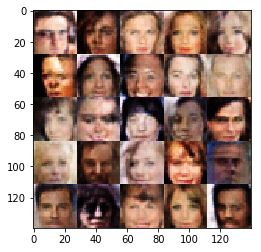

Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.6522...
Epoch 2/2... Discriminator Loss: 1.4017... Generator Loss: 0.9164...
Epoch 2/2... Discriminator Loss: 1.5213... Generator Loss: 0.6197...
Epoch 2/2... Discriminator Loss: 1.4730... Generator Loss: 0.5973...
Epoch 2/2... Discriminator Loss: 1.5639... Generator Loss: 0.4214...
Epoch 2/2... Discriminator Loss: 1.5151... Generator Loss: 0.5009...
Epoch 2/2... Discriminator Loss: 1.5336... Generator Loss: 0.5463...
Epoch 2/2... Discriminator Loss: 1.4830... Generator Loss: 0.5240...
Epoch 2/2... Discriminator Loss: 1.4473... Generator Loss: 0.6106...
Epoch 2/2... Discriminator Loss: 1.5663... Generator Loss: 0.4673...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


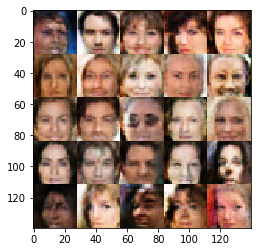

Epoch 2/2... Discriminator Loss: 1.4908... Generator Loss: 0.6310...
Epoch 2/2... Discriminator Loss: 1.5548... Generator Loss: 0.5048...
Epoch 2/2... Discriminator Loss: 1.5385... Generator Loss: 0.5704...
Epoch 2/2... Discriminator Loss: 1.4481... Generator Loss: 0.6322...
Epoch 2/2... Discriminator Loss: 1.4656... Generator Loss: 0.6442...
Epoch 2/2... Discriminator Loss: 1.5773... Generator Loss: 0.5163...
Epoch 2/2... Discriminator Loss: 1.4412... Generator Loss: 0.6164...
Epoch 2/2... Discriminator Loss: 1.4705... Generator Loss: 0.7669...
Epoch 2/2... Discriminator Loss: 1.4498... Generator Loss: 0.7214...
Epoch 2/2... Discriminator Loss: 1.4799... Generator Loss: 0.6850...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


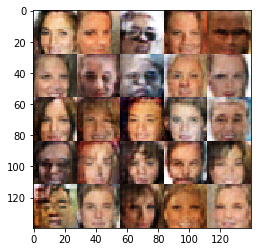

Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.6045...
Epoch 2/2... Discriminator Loss: 1.5204... Generator Loss: 0.6086...
Epoch 2/2... Discriminator Loss: 1.4221... Generator Loss: 0.6513...
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.6633...
Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 0.6498...
Epoch 2/2... Discriminator Loss: 1.4771... Generator Loss: 0.7697...
Epoch 2/2... Discriminator Loss: 1.5071... Generator Loss: 0.5485...
Epoch 2/2... Discriminator Loss: 1.4687... Generator Loss: 0.5691...
Epoch 2/2... Discriminator Loss: 1.4490... Generator Loss: 0.4973...
Epoch 2/2... Discriminator Loss: 1.5316... Generator Loss: 0.5152...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


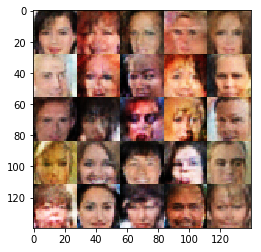

Epoch 2/2... Discriminator Loss: 1.4891... Generator Loss: 0.5220...
Epoch 2/2... Discriminator Loss: 1.4470... Generator Loss: 0.5168...
Epoch 2/2... Discriminator Loss: 1.5523... Generator Loss: 0.9045...
Epoch 2/2... Discriminator Loss: 1.4526... Generator Loss: 0.6865...
Epoch 2/2... Discriminator Loss: 1.5179... Generator Loss: 0.6788...
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.9501...
Epoch 2/2... Discriminator Loss: 1.4636... Generator Loss: 0.6063...
Epoch 2/2... Discriminator Loss: 1.5201... Generator Loss: 0.8641...
Epoch 2/2... Discriminator Loss: 1.5328... Generator Loss: 0.4946...
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 1.0254...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


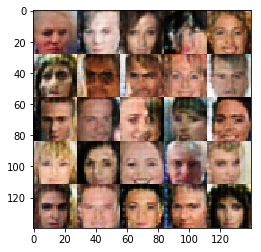

Epoch 2/2... Discriminator Loss: 1.5446... Generator Loss: 0.5455...
Epoch 2/2... Discriminator Loss: 1.5716... Generator Loss: 0.7004...
Epoch 2/2... Discriminator Loss: 1.5391... Generator Loss: 0.5364...
Epoch 2/2... Discriminator Loss: 1.4987... Generator Loss: 0.6408...
Epoch 2/2... Discriminator Loss: 1.5275... Generator Loss: 0.6535...
Epoch 2/2... Discriminator Loss: 1.4618... Generator Loss: 0.5985...
Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.6868...
Epoch 2/2... Discriminator Loss: 1.5111... Generator Loss: 0.6737...
Epoch 2/2... Discriminator Loss: 1.5998... Generator Loss: 0.8459...
Epoch 2/2... Discriminator Loss: 1.5424... Generator Loss: 0.5993...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


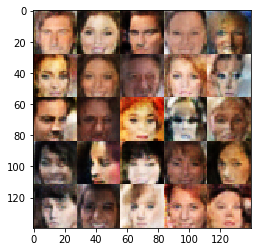

Epoch 2/2... Discriminator Loss: 1.3293... Generator Loss: 0.7523...
Epoch 2/2... Discriminator Loss: 1.4934... Generator Loss: 0.6798...
Epoch 2/2... Discriminator Loss: 1.5471... Generator Loss: 0.4512...
Epoch 2/2... Discriminator Loss: 1.6508... Generator Loss: 0.3831...
Epoch 2/2... Discriminator Loss: 1.4635... Generator Loss: 0.7774...
Epoch 2/2... Discriminator Loss: 1.5151... Generator Loss: 0.4611...
Epoch 2/2... Discriminator Loss: 1.6330... Generator Loss: 0.4192...
Epoch 2/2... Discriminator Loss: 1.4567... Generator Loss: 0.5960...
Epoch 2/2... Discriminator Loss: 1.4615... Generator Loss: 0.6551...
Epoch 2/2... Discriminator Loss: 1.4872... Generator Loss: 0.6382...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


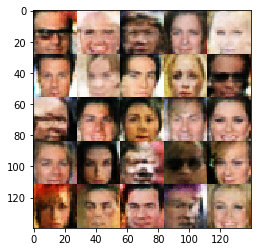

Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 0.6768...
Epoch 2/2... Discriminator Loss: 1.5601... Generator Loss: 0.4491...
Epoch 2/2... Discriminator Loss: 1.4670... Generator Loss: 0.5636...
Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.6960...
Epoch 2/2... Discriminator Loss: 1.4683... Generator Loss: 0.6983...
Epoch 2/2... Discriminator Loss: 1.4953... Generator Loss: 0.7348...
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.6679...
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 0.8346...
Epoch 2/2... Discriminator Loss: 1.5276... Generator Loss: 0.4609...
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.7066...
generator shape, 1-dense: (?, 4096)
generator shape, 1-reshape: (?, 4, 4, 256)
generator shape, 2: (?, 7, 7, 256)
generator shape, 3: (?, 14, 14, 128)
generator shape, logits: (?, 28, 28, 3)


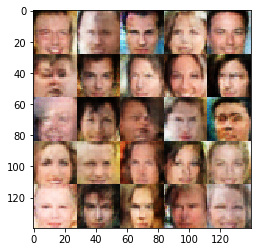

Epoch 2/2... Discriminator Loss: 1.5925... Generator Loss: 0.4162...
Epoch 2/2... Discriminator Loss: 1.4877... Generator Loss: 0.5280...
Epoch 2/2... Discriminator Loss: 1.4331... Generator Loss: 0.6920...
Epoch 2/2... Discriminator Loss: 1.4746... Generator Loss: 0.5579...
Epoch 2/2... Discriminator Loss: 1.5805... Generator Loss: 0.4463...


In [52]:
batch_size = 100
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3

epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)